In [56]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree

In [57]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

In [58]:
tbl_samples

ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.7,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


----------------------

In [59]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'BFcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'BFgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [60]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 75 
 gambiae samples: 92


In [61]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [62]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [63]:
del ann

In [64]:
#Changed from GenotypeDaskArray to GenotypeChunkedArray
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [65]:
# bool biallelic and in genes
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [66]:
#filter to get only biallelic in genes
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

In [67]:
# get just bf coluzzii individuals
gm = {chrom: ga[chrom].take(index_m, axis=1) for chrom in contigs}

In [68]:
#take an equal number of samples
random_index = random.sample(index_s, 75)
gs = {chrom: ga[chrom].take(random_index, axis=1) for chrom in contigs}

In [69]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [70]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [71]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 2278983
seg sites coluzii chrom 3R: 3201821
seg sites coluzii chrom 2R: 3312912
seg sites coluzii chrom 2L: 2748896
seg sites coluzii chrom X: 1108436


In [72]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 2510590
seg sites gambiae chrom 3R: 3428742
seg sites gambiae chrom 2R: 4020649
seg sites gambiae chrom 2L: 2890597
seg sites gambiae chrom X: 1252673


In [73]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [74]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

In [75]:
outgroups = ['epir', 'chri', 'meru', 'mela']

In [76]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [77]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [78]:
len(segreg_c['2L'])

2748896

In [79]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [80]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [81]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [82]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [83]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [84]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [85]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}
alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [86]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [87]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    alt[chrom] = alt_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom].compress(bool_aa_match[chrom], axis=0)
    pos_bial_genes[chrom] = pos_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom].compress(bool_aa_match[chrom], axis=0)

In [88]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [89]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [90]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [91]:
len(bool_no_fixed['2L'])*2

11799372

In [92]:
len(pos_bial_genes['2L'])

5899686

In [93]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [94]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [95]:
chrom = 'X'
assert(af_gambiae_novar_out[chrom].shape[0] == af_gambiae_novar_out[chrom].shape[0] == pos_bial_genes[chrom].shape[0])

## Sanity Check

In [96]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([   82544,   138420,   138857,   139705,   168829,   296109,
         304874,   305123,   398426,   414547,  9205129,  9505086,
        9505172,  9505188,  9505301, 10233123, 10233176, 10233180,
       10274453, 10274892, 10275447, 10276680, 10276868, 10276878,
       10276935, 10276969, 10276974, 10387477, 10433175, 10762090,
       10883390, 10883931, 10885668, 10885781, 10886677, 10904449,
       10905285, 10905431, 10905456, 10913315, 10913523, 10954013,
       11592016, 11592984, 33285114, 33285780], dtype=int32)

In [97]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([   66609,    80272,    81082,    82766,   139762,   139768,
         296897,   303760,   304422,   304440,   305059,   377123,
         413508,   413550,   413551,   413944,  9251399,  9368190,
        9504837,  9509059, 10243325, 10243327, 10243798, 10385594,
       10386086, 10815293, 10815812, 10862596, 10882689, 10885503,
       10885515, 10904429, 10904448, 10905461, 10912700, 10913305,
       10913361, 10913397, 11167839, 11241338, 11591221, 11593158,
       11593718, 33285040, 33285838], dtype=int32)

In [98]:
loc_3L = np.in1d(pos_bial_genes['3L'], fixed_c['3L'])
np.compress(loc_3L, af_coluzzii_novar_out['3L'], axis=0)[:10]

array([[ 1.        ,  0.        ],
       [ 0.99333333,  0.00666667],
       [ 1.        ,  0.        ],
       [ 0.99333333,  0.00666667],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]])

In [99]:
np.compress(loc_3L, af_gambiae_novar_out['3L'], axis=0)[:10]

array([[ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667],
       [ 0.94666667,  0.05333333],
       [ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667],
       [ 0.05333333,  0.94666667]])

In [100]:
np.compress(loc_3L, af_novar_out['chri']['3L'], axis=0)[:10,:2]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

-----------------------------

## Stat

In [101]:
def identify_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    return interval_join

In [102]:
identify_fixex_coluzzii = {chrom: identify_variants_per_gene(chrom, fixed_c, 'coluzzii_segreg') for chrom in contigs}

In [103]:
identify_fixex_gambiae = {chrom: identify_variants_per_gene(chrom, fixed_g, 'gambiae_segreg') for chrom in contigs}

In [104]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [105]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [108]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [109]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [110]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [111]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [112]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001658,1,789,789.0
AGAP001660,1,2686,2686.0
AGAP001674,6,2322,387.0
AGAP001683,31,13434,433.35483870967744
AGAP001684,2,383,191.5


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001569,1,203,203.0
AGAP001674,1,3209,3209.0
AGAP001683,19,17157,903.0
AGAP001690,1,4164,4164.0
AGAP001824,12,10497,874.75


In [113]:
etl.rowlengths(joi_seg_fix_gambiae['X'])

length,count
4,100


In [114]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [115]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  181087.0 
 C genome wide:  662.0 
 A/C genome wide:  273.5453172205438

 B genome wide:  186177.0 
 D genome wide:  585.0 
 B/D genome wide:  318.25128205128203


In [116]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [117]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [118]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [119]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [120]:
with open('/home/randomx/hka/gambiae_hka_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [121]:
with open('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


------------------------------------------------------------

In [122]:
hka_gambiae = etl.fromtsv('/home/randomx/hka/gambiae_hka_summary_beta.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP010316,15,1,1.35317292047
3L,AGAP010313,173,3,2.05758803001
3R,AGAP010302,54,2,2.8047957226
3R,AGAP010294,96,3,4.06761372281
3R,AGAP007737,120,6,15.2508298376
3R,AGAP010290,184,4,3.81501240921
3R,AGAP007732,633,31,81.7214281888
3R,AGAP007736,2299,48,45.3891959405
3R,AGAP010184,4559,3,2.3568051817
3R,AGAP010286,409,6,3.61505643975


In [123]:
hka_coluzzii = etl.fromtsv('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP010314,120,1,0.0318994500595
3L,AGAP010310,118,3,2.71337336011
3L,AGAP010313,112,5,9.32563208242
3L,AGAP010742,1949,1,1.44959707401
3L,AGAP010788,1306,2,0.522601199367
3L,AGAP010317,31,4,20.4043809663
3R,AGAP009801,733,1,0.324928040885
3R,AGAP007761,727,4,0.215314722705
3R,AGAP010147,844,5,0.371496633581
3R,AGAP010297,61,2,2.09782783164


In [124]:
hka_gambiae.convert('score_g', float).select(lambda r: (r.chrom == 'X') & (r.score_g >= 1.3)).rowlengths() 

length,count
5,56


In [125]:
hka_coluzzii.convert('score_c', float).select(lambda r: (r.chrom == 'X') & (r.score_c >= 1.3)).rowlengths() 

length,count
5,52


-----------------------------

## Distruptive selection

In [126]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.display(10)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007732,525,25,54.3486933436,633,31,81.7214281888,136.0701215324
X,AGAP013341,37,10,110.595539115,33,4,22.4765841881,133.0721233031
X,AGAP001035,67,13,110.786262569,109,5,11.3266754184,122.1129379874
X,AGAP001076,119,10,38.4766077275,78,10,67.4529169256,105.9295246531
X,AGAP001023,177,6,8.44952666879,281,19,70.5842294148,79.03375608359
3R,AGAP007736,1966,29,13.9424575794,2299,48,45.3891959405,59.3316535199
X,AGAP001026,32,5,31.7591254698,39,4,19.2554122217,51.014537691499996
3R,AGAP007731,146,10,31.314540398,197,8,16.7709893075,48.085529705499994
X,AGAP001037,17,4,34.3866942892,30,2,5.00649924533,39.39319353453
X,AGAP000819,18,4,32.8000250721,38,2,3.98622367513,36.78624874723


In [127]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007732,525,25,54.3486933436,633,31,81.7214281888,136.0701215324
X,AGAP013341,37,10,110.595539115,33,4,22.4765841881,133.0721233031
X,AGAP001035,67,13,110.786262569,109,5,11.3266754184,122.1129379874
X,AGAP001076,119,10,38.4766077275,78,10,67.4529169256,105.9295246531
3R,AGAP007736,1966,29,13.9424575794,2299,48,45.3891959405,59.3316535199
X,AGAP001026,32,5,31.7591254698,39,4,19.2554122217,51.014537691499996
3R,AGAP007731,146,10,31.314540398,197,8,16.7709893075,48.085529705499994
2L,AGAP006634,14439,2,11.2952008169,19773,1,13.7886692343,25.0838700512


## Indentify genes which experienced private selection

In [128]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000822,6,3,41.5211699388,None,None,0
X,AGAP013181,30,5,33.6274701266,None,None,0
3R,AGAP010305,11,3,26.6540217572,None,None,0
3L,AGAP010317,31,4,20.4043809663,27,1,0.78610368567
X,AGAP001031,16,3,19.5918952584,20,1,1.04451282125
X,AGAP001044,7,2,15.2818088608,24,1,0.880696553589
3R,AGAP010304,56,4,11.6251989737,None,None,0
X,AGAP000829,134,5,7.67243352854,322,1,0.203061479037
X,AGAP000937,17,2,7.27442100213,20,1,1.04451282125
X,AGAP001038,19,2,6.58071896023,25,1,0.846972102628


In [129]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,34,5,35.0817572797
X,AGAP001041,18,1,0.994879324639,17,3,21.64108628
X,AGAP001051,None,None,0,7,2,17.7271161896
X,AGAP000949,None,None,0,47,4,16.1348914193
X,AGAP001083,38,1,0.466121033299,25,3,15.3932646501
X,AGAP001042,None,None,0,9,2,14.5339980673
X,AGAP001047,30,1,0.603908216676,45,3,8.84823444318
3R,AGAP010289,21,1,0.861228932036,18,2,8.02813833498
X,AGAP001068,88,1,0.120595912514,96,4,7.87854574963
X,AGAP000837,145,1,0.0155836173615,242,6,7.03012953991


## Plot genome wide HKA

In [130]:
def center_pos(r):
    start = r.start
    end = r.end
    center = ((end - start) / 2) + start
    return int(center)

In [131]:
tbl_genes  = (etl
    .fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .addfield('center_gene', center_pos)
)
tbl_genes.display(10)

type,start,end,gene,center_gene
gene,157348,186936,AGAP004677,172142
gene,203779,205293,AGAP004678,204536
gene,207894,210460,AGAP004679,209177
gene,271285,271815,AGAP004680,271550
gene,358329,359280,AGAP004681,358804
gene,433503,461627,AGAP004682,447565
gene,485698,488369,AGAP004683,487033
gene,493039,493543,AGAP004684,493291
gene,493579,497632,AGAP004685,495605
gene,742004,747057,AGAP004686,744530


In [132]:
pos_hka_gambiae = hka_gambiae.join(tbl_genes, key='gene')
pos_hka_coluzzii = hka_coluzzii.join(tbl_genes, key='gene')

In [133]:
def plot_genome_hka(species, chrom):
    if species == 'gambiae':   
        tbl_plot = pos_hka_gambiae.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_g'].list()
    if species == 'coluzzii':
        tbl_plot = pos_hka_coluzzii.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_c'].list()
    fig, ax = plt.subplots(figsize=(15,2))
    x = tbl_plot['center_gene'].list()
    
    ax.set_ylabel('HKA test score', fontsize=14)
    ax.set_xlabel('Positions', fontsize=14)
    ax.set_title('An. gambiae chrom: %s' % chrom, fontsize=14)
    ax.plot(x, y, 'or')
    len_chrom = {'X': 244e5, '3R': 532e5, '3L': 42e6, '2R': 616e5, '2L':493e5}
    ax.set_xlim(0, len_chrom[chrom])
    if chrom == 'X':
        ax.set_ylim(0, 80)
    else:
        ax.set_ylim(0, 40)
    sns.despine(offset=10)

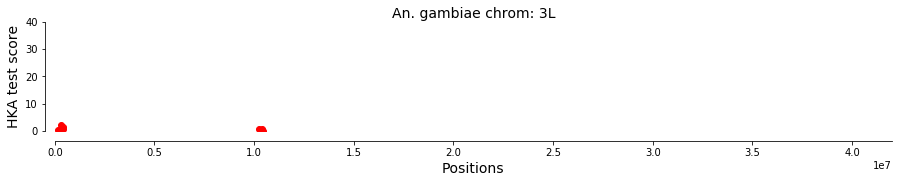

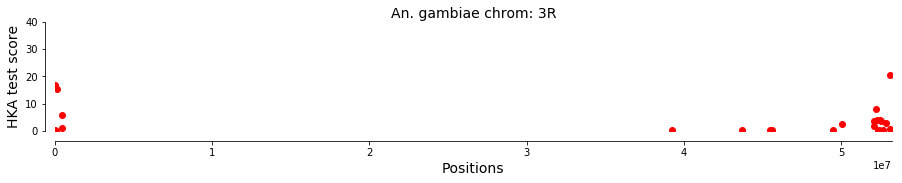

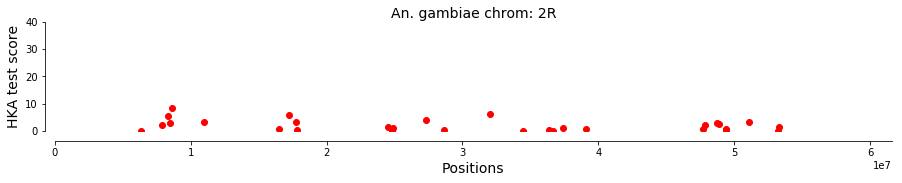

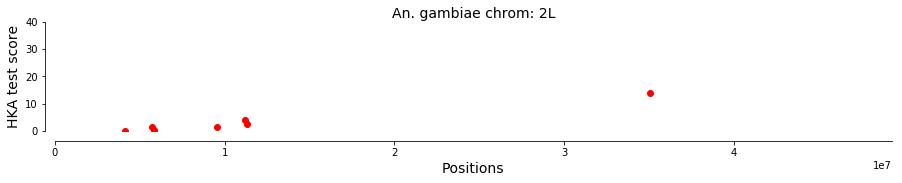

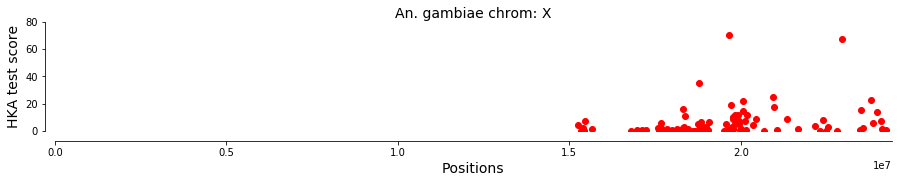

In [134]:
for chrom in contigs:
    plot_genome_hka('gambiae', chrom)

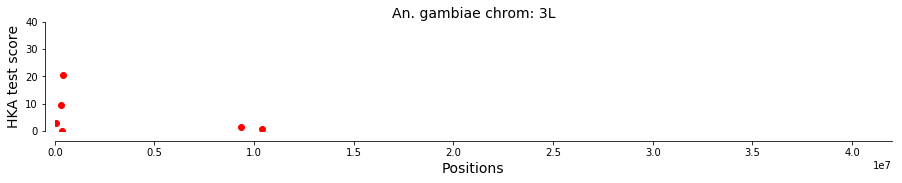

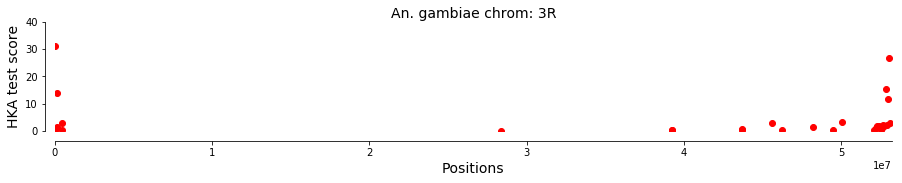

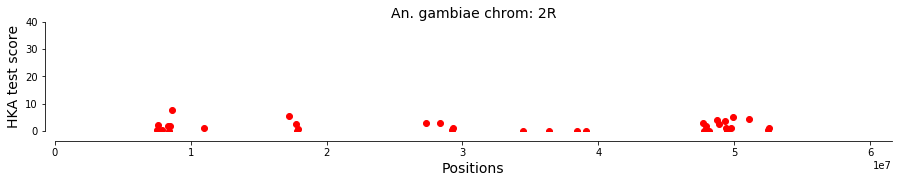

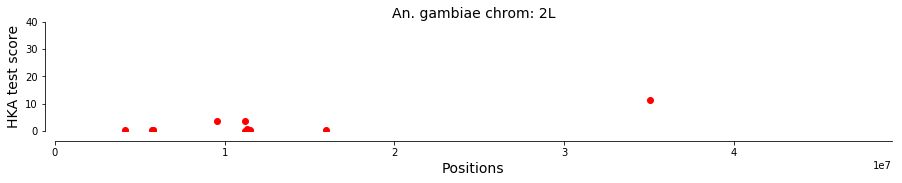

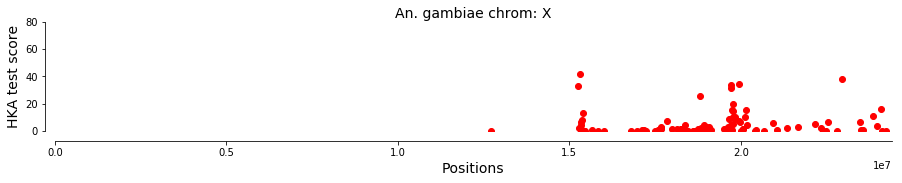

In [135]:
for chrom in contigs:
    plot_genome_hka('coluzzii', chrom)

## Plot seg fixed An coluzzii

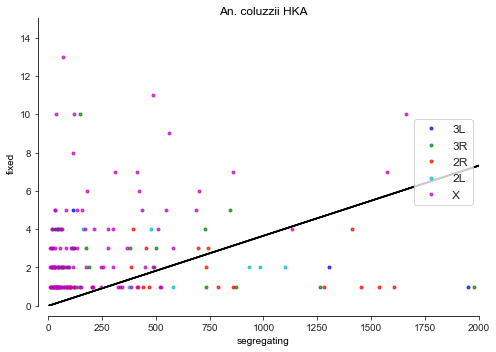

In [136]:
fig, ax = plt.subplots(figsize=(7,5))
for num, chrom in enumerate(contigs):
    
    colour = {0:'b', 1:'g', 2:'r', 3: 'c', 4:'m'}
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed,  colour[num] + '.', alpha=0.7, label=chrom)
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii], 'k')
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('An. coluzzii HKA')
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    ax.legend(loc=7, fontsize='large')
    sns.despine(offset=10)

fig.tight_layout()

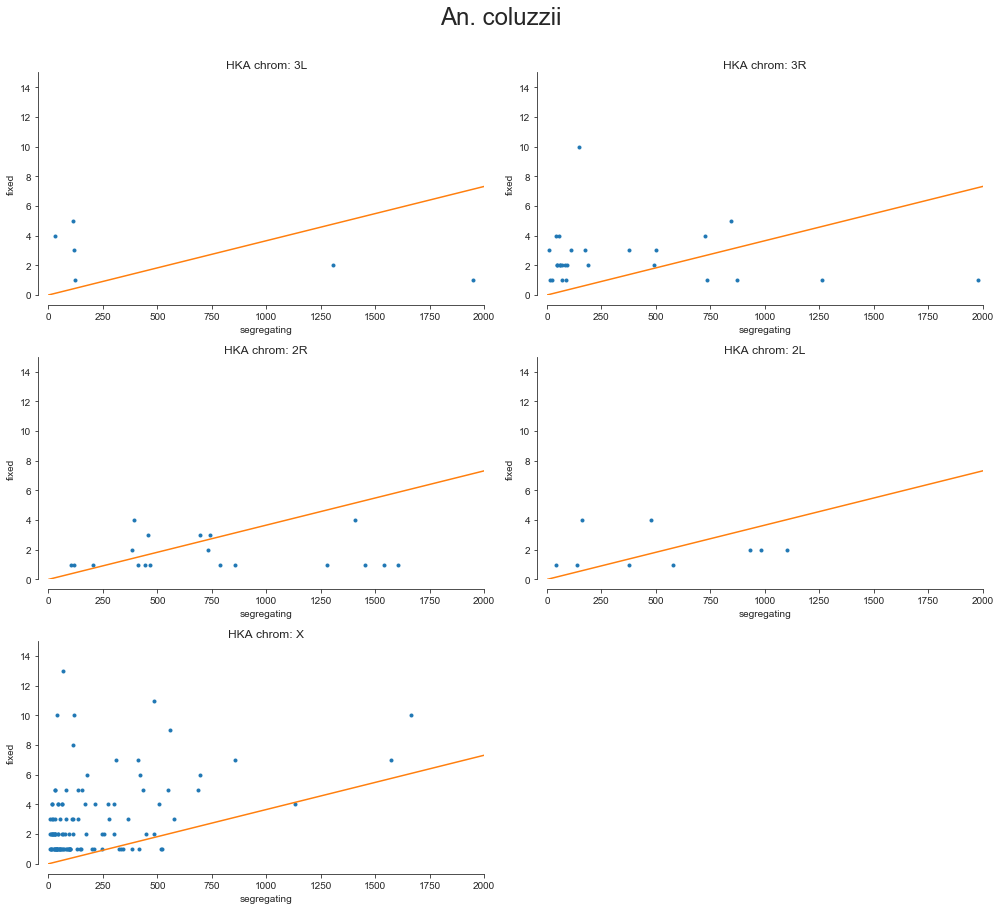

In [137]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. coluzzii', y=1.05, fontsize=24)
fig.tight_layout()

## Plot seg fixed An. gambiae

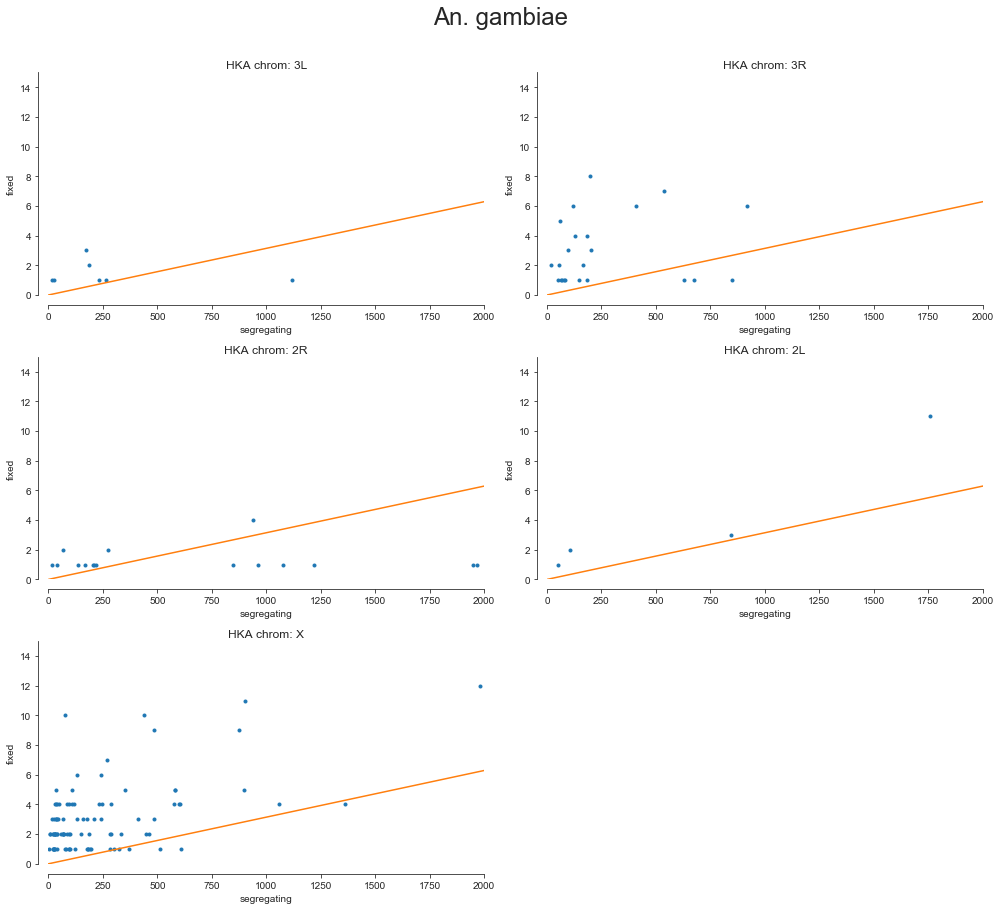

In [138]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, B_geno_wide_gambiae], [0, D_geno_wide_gambiae])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. gambiae', y=1.05, fontsize=24)
fig.tight_layout()

## Plot homogeneity test

In [139]:
# get just the gene matching gambiae coluzzii
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [140]:
joi_gambiae_coluzzii['2L'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP004827,2,1101,550.5,3,845,281.6666666666667
AGAP004902,6,2250,375.0,11,1757,159.72727272727272
AGAP005073,4,162,40.5,2,104,52.0
AGAP005165,10,8321,832.1,5,7803,1560.6
AGAP006634,2,14439,7219.5,1,19773,19773.0


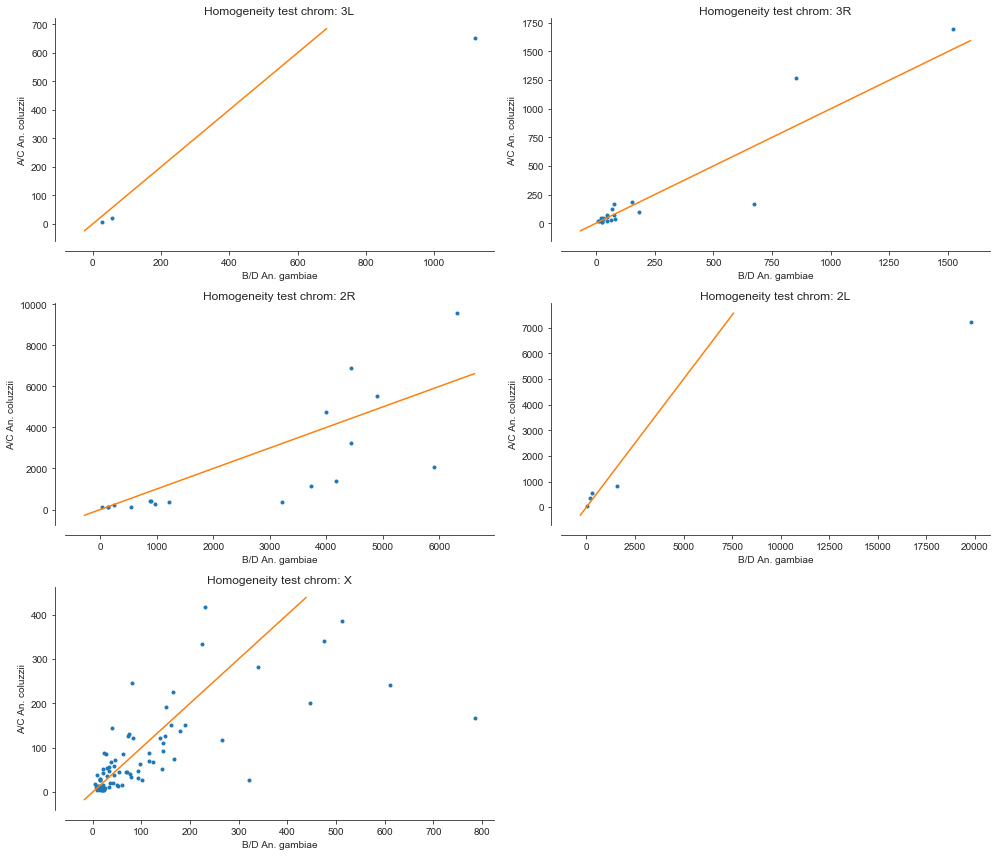

In [141]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    
    AC = joi_gambiae_coluzzii[chrom]['A/C (i.e.seg/fix)'].list()
    BD = joi_gambiae_coluzzii[chrom]['B/D (i.e.seg/fix)'].list()
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(BD, AC, '.')
    lim = max(ax.get_xlim(), ax.get_ylim())
    ax.plot(lim, lim)
    #ax.set_xlim(0,2000)
    #ax.set_ylim(0,2000)
    ax.set_title('Homogeneity test chrom: %s' % chrom)
    ax.set_ylabel('A/C An. coluzzii')
    ax.set_xlabel('B/D An. gambiae')
    sns.set_style('ticks')
    sns.despine(offset=10)

fig.tight_layout()

## Homogeneity test

In [142]:
joi_gambiae_coluzzii[chrom]

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP000819,4,18,4.5,2,38,19.0
AGAP000829,5,134,26.8,1,322,322.0
AGAP000832,1,40,40.0,1,77,77.0
AGAP000833,5,81,16.2,3,179,59.666666666666664
AGAP000835,1,68,68.0,1,123,123.0


In [143]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [144]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [145]:
with open('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [146]:
homog_tbl = (etl.fromtsv('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP000847,2.03942723481
X,AGAP001035,1.97067066779
X,AGAP000829,1.80250762781
X,AGAP000981,1.05153076125
X,AGAP000833,0.862572362616
X,AGAP000998,0.825105959951
X,AGAP001023,0.681353561134
X,AGAP000819,0.660786371453
X,AGAP001037,0.495242354538
X,AGAP013341,0.487233375308


In [147]:
join_hom_direct = homog_tbl.join(direct_select, key='gene')
join_hom_direct.displayall()

chrom,gene,score,chrom,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP001026,0.0911342988974,X,32,5,31.7591254698,39,4,19.2554122217,51.014537691499996
X,AGAP001035,1.97067066779,X,67,13,110.786262569,109,5,11.3266754184,122.1129379874
X,AGAP001076,0.295311757658,X,119,10,38.4766077275,78,10,67.4529169256,105.9295246531
2L,AGAP006634,0.105348743521,2L,14439,2,11.2952008169,19773,1,13.7886692343,25.0838700512
3R,AGAP007731,0.397181553582,3R,146,10,31.314540398,197,8,16.7709893075,48.085529705499994
3R,AGAP007732,0.0124927964829,3R,525,25,54.3486933436,633,31,81.7214281888,136.0701215324
3R,AGAP007736,0.757048910916,3R,1966,29,13.9424575794,2299,48,45.3891959405,59.3316535199
X,AGAP013341,0.487233375308,X,37,10,110.595539115,33,4,22.4765841881,133.0721233031


---------------------------

## Homogen selection coluzzii: (C/A > D/B)

In [148]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [149]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP010313,5,112,22.4,3,173,57.666666666666664,3L
AGAP010317,4,31,7.75,1,27,27.0,3L
AGAP010788,2,1306,653.0,1,1119,1119.0,3L
AGAP001674,6,2322,387.0,1,3209,3209.0,2R
AGAP001683,31,13434,433.35483870967744,19,17157,903.0,2R


In [150]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP003997,2R,2.70591011582
AGAP000847,X,2.03942723481
AGAP001035,X,1.97067066779
AGAP001683,2R,1.82333404602
AGAP000829,X,1.80250762781
AGAP001674,2R,1.30052052747
AGAP001824,2R,1.27508310059
AGAP000981,X,1.05153076125
AGAP000833,X,0.862572362616
AGAP000998,X,0.825105959951


In [151]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP004902,2L,0.8609160745
AGAP007736,3R,0.757048910916
AGAP001023,X,0.681353561134
AGAP001083,X,0.412862666118
AGAP000837,X,0.411513322782
AGAP010295,3R,0.397855756368
AGAP001068,X,0.358725441804
AGAP001091,X,0.32021569939
AGAP001076,X,0.295311757658
AGAP001053,X,0.275294859436


## Plot the distribution of the homogen test for the top 20 genes (all genes allowed)


In [152]:
homogen_select_gambiae.rowlengths()

length,count
3,51


In [153]:
homogen_select_coluzzii.rowlengths()

length,count
3,79


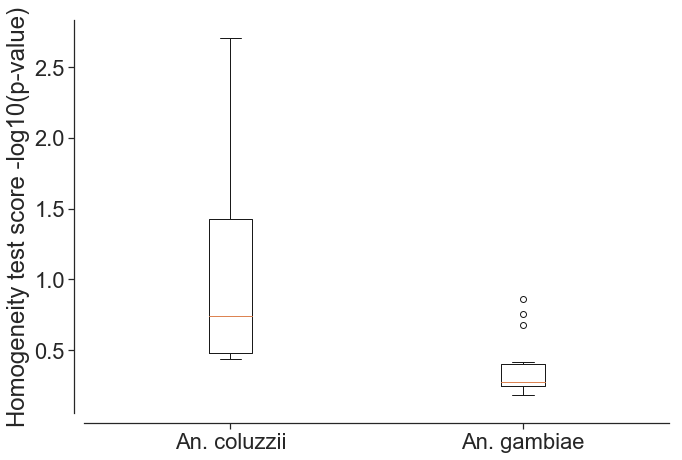

In [169]:
fig, ax = plt.subplots(figsize=(10,7))
gambiae_hom = homogen_select_gambiae['score'].list()[:20]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:20]
ax.boxplot([coluzzii_hom, gambiae_hom])
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

## Plot the distribution of the homogen test genes under private selection

In [170]:
priv_sel_gambiae

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,34,5,35.0817572797
X,AGAP001041,18,1,0.994879324639,17,3,21.64108628
X,AGAP001051,None,None,0,7,2,17.7271161896
X,AGAP000949,None,None,0,47,4,16.1348914193
X,AGAP001083,38,1,0.466121033299,25,3,15.3932646501


In [171]:
private_hom_gambiae = homogen_select_gambiae.join(priv_sel_gambiae, key='gene').sort('score', reverse=True)
private_hom_gambiae.rowlengths()

length,count
10,24


In [172]:
private_hom_coluzzii = homogen_select_coluzzii.join(priv_sel_coluzzii, key='gene').sort('score', reverse=True)
private_hom_coluzzii.rowlengths()

length,count
10,18


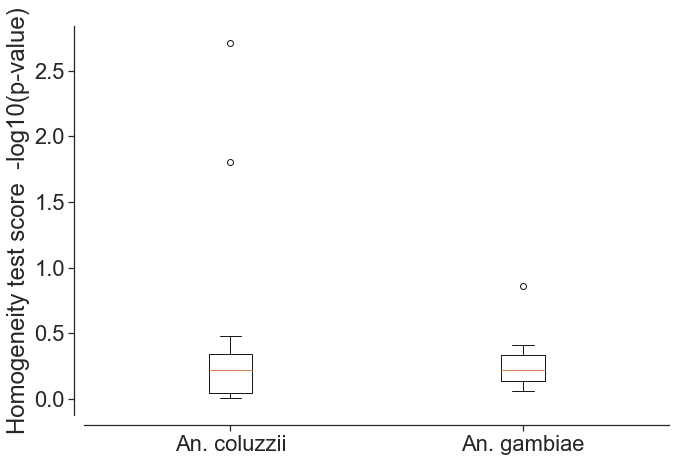

In [173]:
fig, ax = plt.subplots(figsize=(10,7))
gambiae_hom = private_hom_gambiae['score'].list()[:18]
coluzzii_hom  = private_hom_coluzzii['score'].list()
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score  -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)
fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top11_private_selec_v2.png', dpi=500)

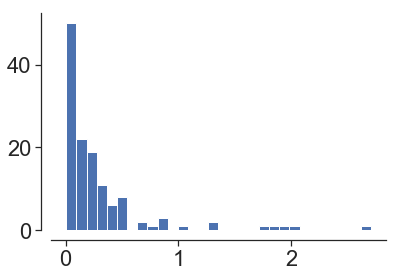

In [174]:
#plot homog score distribution
fig, ax = plt.subplots()
x = [float(i) for i in homog_tbl['score'].list()]
val = ax.hist(x, bins=30)
sns.despine(offset=10)